**1 Discrete Cosine Transform (DCT)**

1.1  Derive a 4*4 DCT matrix starting from expressing the formula of 1-D DCT

1.2 

Given a 1-D signal of (2,−1,0,1)^T, obtain its DCT transformed signal.

**How would we compute the inverse transform of a given 1-D DCT transformed signal, in relation to the matrix form above?**

**2 Basic JPEG Compression**

In [1]:
from Utility import blockproc 
from PIL import Image 
from matplotlib.pyplot import imshow

import numpy as np 


2.1 Optimal Color Space 


Image size (512, 768, 3)


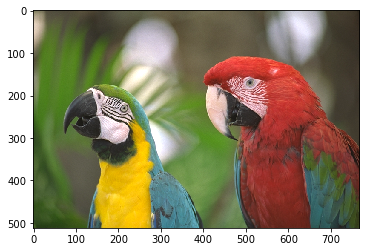

In [2]:
#1. Reading & showing input sample image, printing the size
birds = Image.open('birds.ppm')
imshow(birds)
print('Image size', np.array(birds).shape)


In [3]:
#2. rgb2ycber 
def rgb2ycber(img):
    """
    input: img (image array)
    output: ycbcr(transformed color space image array)
    """
    img_size = np.array(img).shape
    ycbcr = np.zeros(img_size)

    for i in range(img_size[0]):
        for j in range(img_size[1]):
            rgb2ycbcr_trans_mat = np.array ([[0.299,0.587,0.114],
            [-0.168736,-0.331264,0.5],
            [0.5,-0.418688,-0.081312]])            
            rgb_array = np.array([img[i,j,0], img[i,j,1], img[i,j,2]])
            ycbcr[i,j,:] += np.array([0,127.5,127.5]) + np.matmul(rgb2ycbcr_trans_mat, rgb_array)
            
    return ycbcr


In [4]:
# ycbcr2rgb 
def ycbcr2rgb(img):
    """
    input: img (image array)
    output: rgb(transformed color space image array)
    """
    img_size = np.array(img).shape
    rgb = np.zeros(img_size)

    for i in range(img_size[0]):
        for j in range(img_size[1]):
            rgb2ycbcr_trans_mat = np.linalg.inv(np.array ([[0.299,0.587,0.114],[-0.168736,-0.331264,0.5],[0.5,-0.418688,-0.081312]]))    #inverse matrix in this case 
            ycbcr_array = np.array([img[i,j,0], img[i,j,1], img[i,j,2]])  
            rgb[i,j,:] += np.matmul(rgb2ycbcr_trans_mat, ycbcr_array - np.array([0,127.5,127.5]) )
            
    return rgb

In [5]:
ycbcr_result = rgb2ycber(np.array(birds))
rgb_result = ycbcr2rgb(ycbcr_result)

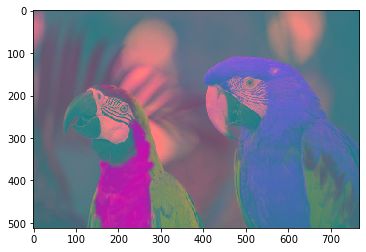

In [6]:
imshow(np.uint8(ycbcr_result))


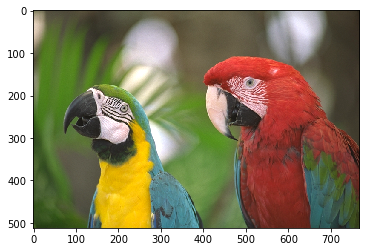

In [7]:
imshow(np.uint8(rgb_result))

**2.2 Downsample** 

In [8]:
def downsample(inputmatrix, w):
    """
    input: (inputmatrix)given matrix which has to be downsampled
            W(blocksize)
    output: downsamp_mat
    """
    img_size = inputmatrix.shape
    downsamp_mat = np.zeros((img_size[0]//w, img_size[1]//w)) #flooring operator instead of regular division to avoid fractional part
    block__image_avg = blockproc(inputmatrix, [w,w], np.mean)
    
    for i in range(0, img_size[0], w):
        for j in range(0, img_size[1], w):
            
            downsamp_mat[i//w,j//w] = block__image_avg[i, j]
            
    return downsamp_mat

In [9]:
def upsample(inputmatrix, w):
    """
    input: (inputmatrix)given matrix which has to be upsampled
            W(blocksize)
    output: upsamp_mat
    """
    img_size = inputmatrix.shape
    upsamp_mat = np.zeros((img_size[0]*w, img_size[1]*w))
    
    for i in range(img_size[0]*w ): #-w+1 or -w 
        for j in range(img_size[1]*w):
            for k in range(w):
                for l in range(w):
                    #upsamp_mat[i*w,j*w] = block__image_avg[i//w, j//w] #will not give anything in interpolated data if we take i*w we need data between i - i*w too
                    upsamp_mat[i+k,j+l] = inputmatrix[i//w, j//w]

            
    return upsamp_mat

(64, 96)

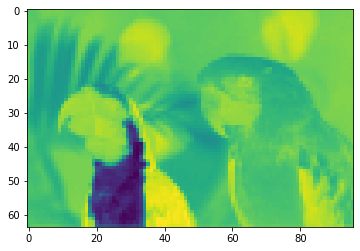

In [10]:
#cb channel
downsampled_cb = downsample(ycbcr_result[:,:,1],w=8)
imshow(np.uint8(downsampled_cb))
downsampled_cb.shape

(64, 96)

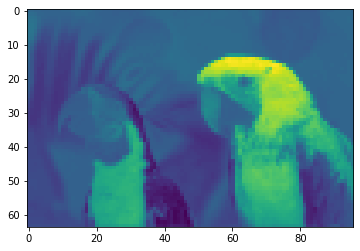

In [11]:
#cr channel
downsampled_cr = downsample(ycbcr_result[:,:,2],w=8)
imshow(np.uint8(downsampled_cr))
downsampled_cr.shape

In [12]:
upsampled_cb = upsample(downsampled_cb,w=8)
imshow(np.uint8(upsampled_cb))
upsampled_cb.shape

IndexError: index 768 is out of bounds for axis 1 with size 768

**2.3 DCT**
Transform all channels separately using DCT

In [13]:
from scipy.fftpack import dct, idct


In [14]:
def dct2D(img):
    return dct(dct(img, norm='ortho').T, norm='ortho')

In [15]:
def idct2D(img):
    return idct(idct(img, norm='ortho').T, norm='ortho')    


**2.4 Quantization**

Quantize image blocks

In [16]:
def quanmat(img):
    q_mat = np.array([[8 ,19, 26, 29],
                [19,26,29,34],
                [22,27,32,40],
                [26,29,38,56]])         
    img_size = img.shape
    quant_matrix = np.zeros((img_size))
    for i in range(0,img_size[0]-1):
        for j in range(0,img_size[1]-1):
            quant_matrix[i,j] = img[i,j]//q_mat[i,j]
    return quant_matrix

In [17]:
def dequanmat(img):
    q_mat = np.array([[8 ,19, 26, 29],
                [19,26,29,34],
                [22,27,32,40],
                [26,29,38,56]])
        
    invquant_matrix = np.zeros((img.shape))
    for i in range(0,img_size[0]-1):
        for j in range(0,img_size[1]-1): 
            invquant_matrix[i,j] = img[i,j]*q_mat[i,j]
                         
    return invquant_matrix

**2.5 Execution of DCT and Quantization**

In [18]:
dct_y =  blockproc(ycbcr_result[:,:,0], [8,8], dct2D)
y_dash = blockproc(dct_y,[4,4],quanmat )

dct_cb =  blockproc(downsampled_cb, [8,8], dct2D)
cb_dash = blockproc(dct_cb,[4,4],quanmat )

dct_cr =  blockproc(downsampled_cr, [8,8], dct2D)
cr_dash = blockproc(dct_cr,[4,4],quanmat )



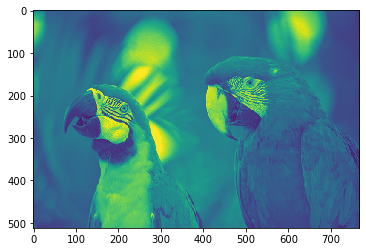

In [19]:
#Display images

#original y channel 
imshow(np.uint8(ycbcr_result[:,:,0]))

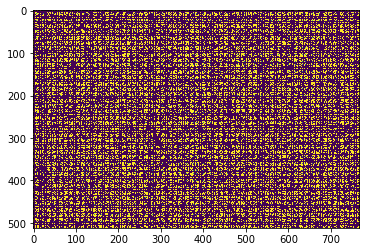

In [20]:
#resulting y_dash

imshow(np.uint8(y_dash))

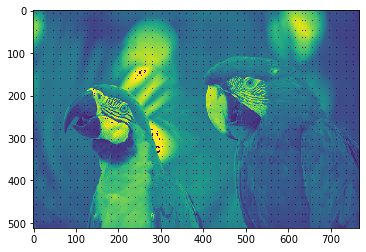

In [21]:

#difference between original y and y_dash

imshow(np.uint8(np.abs(ycbcr_result[:,:,0] - y_dash)))

**2.6 Encoding**

Huffmann coding on channels individually 

In [22]:
from dahuffman import HuffmanCodec

In [23]:
def encodemat(img):
    #flatten matrix into vector
    img_flatten = img.flatten()
    symbol, freq = np.unique(img, return_counts = True) #symbol and their frequency are provided in huffmancodec as dictionary as given in docs 
    #creating dict 

    huffmann_input_dict = {symbol[i]: freq[i] 
    #codec = HuffmanCodec.from_frequencies({'A': 5, 'B': 4, 'C': 3, 'D': 2, 'E': 1}) #from docs

    for i in range(len(symbol))}
    
    codec = HuffmanCodec.from_frequencies(huffmann_input_dict)
    encoded = codec.encode(img_flatten)
    
    return codec, encoded

In [24]:
def decodemat(img_encoded, codec):    
    decoded = codec.decode(img_encoded)
    decoded = np.array(decoded)   
    return np.array(decoded)

In [25]:
y_codec, y_encoded  = encodemat(y_dash)
cb_codec, cb_encoded = encodemat(cb_dash)
cr_codec, cr_encoded = encodemat(cr_dash)

In [26]:
# Lengths of the encoded channels:

print(len(y_encoded))
print(len(cb_encoded))
print(len(cr_encoded))

75515
1173
1168


**2.7 Decompression**

